In [1]:
import pymc3 as pm
import arviz as az
import theano as T
import theano.tensor as tt

import numpy as np
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
tau_m = 0.01
J = -1 * tau_m

def approx_q(nu_bar,alpha_0,tau_I):
    
    #tau_I = paras['tau_I']
    #alpha_0 = paras['alpha_0']
    #nu_bar = paras['nu_bar']
    
    nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )
    tau_q = 2. * (tau_I + tau_m)
    q_0 = alpha_0**2 / J**2.
        
    eps = tau_q * ( nu_bar**2 + q_0 ) / ( nu_bar + 2. * tau_q * (nu_bar**2 + q_0) )
    
    q = 1. / np.sqrt( 1. + 2 * tau_q * ( nu_bar + q_0 / nu_bar ) ) * \
        ( 1. + tau_q * ( nu_bar + q_0 / nu_bar ))**( 1. - eps ) * \
        nu_max**( 2. * eps ) * nu_bar**( 2. - 2. * eps )
    
    return q

def p_nu(NU,gamma,delta,nu_max):

    return gamma / ( nu_max * np.sqrt( -np.pi * np.log( NU / nu_max ) ) ) * \
        np.exp( - delta**2/2.) * ( NU / nu_max )**(gamma**2 - 1) * \
        np.cosh( gamma * delta * np.sqrt( -2 * np.log( NU / nu_max) ) )

def logP_nu(NU,gamma,delta,nu_max):
    
    return - tt.log( nu_max / gamma * np.sqrt( -np.pi * tt.log( NU / nu_max ) ) ) - delta**2 / 2 + \
        ( gamma**2 - 1 ) * tt.log( NU / nu_max ) + \
        np.log( np.cosh( gamma * delta * np.sqrt( -2 * tt.log( NU / nu_max ) ) ) )

def logp_raw(NU,nu_bar,alpha_0,tau_I):
    
    # introduce checks for consistency, etc

    nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )

    q = approx_q(nu_bar,alpha_0,tau_I)

    sigma_I = np.sqrt(J**2 * nu_bar / ( 2 * tau_I ))
    sigma_V = np.sqrt(sigma_I**2 * tau_I / (tau_I + tau_m))
    alpha = np.sqrt(J**2 * q + alpha_0**2)

    selfcon_nu = nu_bar/nu_max * np.sqrt( alpha**2/sigma_V**2 + 1)
    selfcon_q = q/nu_max**2 * np.sqrt( 2*alpha**2/sigma_V**2 + 1)

    #if ((selfcon_nu < 1) and (selfcon_q < 1)):

    gamma = sigma_V / alpha

    I_0 = np.sqrt( -( alpha**2 + sigma_V**2 ) * np.log( ( nu_bar / nu_max )**2 * ( alpha**2/sigma_V**2 + 1 ) ) )
    delta = I_0 / alpha
    
    p_ = p_nu(NU,gamma,delta,nu_max)
    logP_ = logP_nu(NU,gamma,delta,nu_max)
    
    return p_, logP_

In [3]:
## create data for inference, or read from model
%cd ..
from create_measures import *
res = create_measures(L=1,S=[1,2],N=30,rerun=True)
print(res)

/home/wollex/Data/Documents/Science/WolfGroup/DarkMatter/Programme
{'rates': masked_array(
  data=[[0.05990746, 0.07126219, 0.25084947, 0.27339908],
        [0.59705836, 1.01241286, 0.99554186, 0.73687462],
        [0.11216449, 0.4762421 , 1.68197538, 0.56195835],
        [0.02173462, 1.42631904, 0.34981938, 1.0324744 ],
        [0.17166273, 1.04174484, 0.14388614, 0.21018111],
        [0.0274301 , 0.1227647 , 0.21447437, 1.48520569],
        [0.06399871, 0.16742902, 0.6520094 , 0.1190956 ],
        [0.43768855, 0.20813885, 0.77709287, 0.2499769 ],
        [1.12910459, 0.15639503, 0.24458432, 0.20930047],
        [3.30176536, 4.20329208, 1.89217951, 0.21614186],
        [0.59314738, 0.62674193, 2.30587617, 0.00721805],
        [0.59585157, 0.21357446, 1.91362681, 2.95874881],
        [3.59235539, 0.92000504, 1.32986131, 0.12100927],
        [0.26269253, 1.29447379, 0.31936863, 0.10998822],
        [0.32442053, 1.07610533, 3.84031836, 0.61766718],
        [1.84541526, 1.27169362, 0.1407

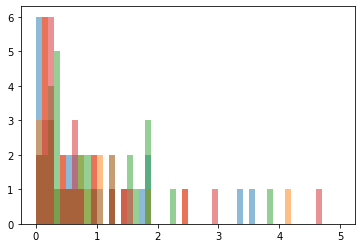

In [4]:
NU = np.squeeze(res['rates_T'])
#NU[NU==0] = 0.001
groups = np.array([len(rates)*[i] for i,rates in enumerate(NU.T)]).flatten()

n = NU.shape[1] # number of distinct tuples of (animals, hemispheres, layers)
obs_nu_bar = np.mean(NU,axis=0)   # should have 

for i in range(n):
    plt.hist(NU[:,i],np.linspace(0,5,51),alpha=0.5)
    
plt.show()

In [5]:
nnn = NU.flatten()
np.min(NU)

0.005

In [6]:
obs_nu_bar

masked_array(data=[0.96455556, 0.77305556, 0.88472222, 0.92772222],
             mask=False,
       fill_value=1e+20)

In [7]:
NU[groups]

masked_array(
  data=[[0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],
        [0.055     , 0.07166667, 0.24166667, 0.26833333],


RV : 


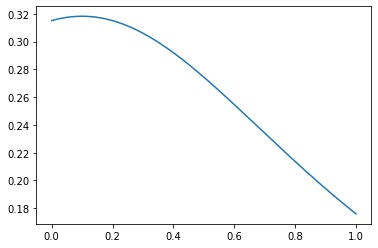

In [8]:
from scipy.stats import t 
x = np.linspace(0,1,1001);
numargs = t .numargs 

a = 1
b = 0.1
rv = t (a, b) 


print ("RV : \n", rv) 

plt.plot(x, rv.pdf(x))

#distribution = np.linspace(0, np.minimum(t.dist.b, 3)) 
#print("Distribution : \n", distribution) 

In [10]:
NU

masked_array(
  data=[[5.50000000e-02, 7.16666667e-02, 2.41666667e-01, 2.68333333e-01],
        [5.80000000e-01, 9.71666667e-01, 9.83333333e-01, 7.50000000e-01],
        [1.31666667e-01, 4.86666667e-01, 1.66333333e+00, 5.80000000e-01],
        [2.33333333e-02, 1.40166667e+00, 3.36666667e-01, 9.91666667e-01],
        [1.71666667e-01, 1.08333333e+00, 1.78333333e-01, 1.91666667e-01],
        [2.50000000e-02, 1.40000000e-01, 2.25000000e-01, 1.53666667e+00],
        [6.16666667e-02, 1.48333333e-01, 6.38333333e-01, 1.13333333e-01],
        [4.25000000e-01, 2.38333333e-01, 7.38333333e-01, 2.43333333e-01],
        [1.04333333e+00, 1.63333333e-01, 2.18333333e-01, 2.10000000e-01],
        [3.36500000e+00, 4.19666667e+00, 1.89333333e+00, 2.21666667e-01],
        [5.93333333e-01, 6.48333333e-01, 2.24833333e+00, 5.00000000e-03],
        [6.25000000e-01, 2.11666667e-01, 1.87500000e+00, 2.94833333e+00],
        [3.56500000e+00, 9.50000000e-01, 1.25666667e+00, 1.15000000e-01],
        [2.50000000e-01,

In [11]:
with pm.Model() as model:
    # replace normals with student-t distributions
    #mu_gamma = pm.HalfNormal('mu_gamma',sigma=1.);
    sigma_gamma = pm.HalfNormal('sigma_gamma',sigma=1.);
    
    gamma = pm.HalfNormal('gamma',sigma=sigma_gamma,shape=n);
    
    
    mu_nu_max = pm.Normal('mu_nu_max',mu=20.,sigma=5.);
    sigma_nu_max = pm.Normal('sigma_nu_max',mu=5.,sigma=2.);
    
    nu_max = pm.Normal('nu_max',mu=mu_nu_max,sigma=sigma_nu_max,shape=n);
    
    
    
    #mu_delta = pm.HalfNormal('mu_delta',sigma=5.);
    sigma_delta = pm.HalfNormal('sigma_delta',sigma=2.);
    
    #tau_I = pm.TruncatedNormal('tau_I',mu=mu_tau_I,sigma=sigma_tau_I,lower=0.,upper=0.1,shape=n);
    delta = pm.HalfNormal('delta',sigma=sigma_delta,shape=n);
    
    
    def likelihood(NU):
        # introduce checks for consistency, etc
        
        logP_ = logP_nu(NU,gamma,delta,nu_max)
        #logP_ = tt.switch(tt.lt(selfcon_nu,1), logP_, -10000.)
        #logP_ = tt.switch(tt.lt(selfcon_q,1), logP_, -10000.)
        logP_ = tt.switch(tt.isnan(logP_), -10000., logP_)
        
        tt.printing.Print('logP_')(tt.sum(logP_))

        #logP_ = tt.switch((selfcon_nu < 1) and (selfcon_q < 1), logP_.sum(), -10000.)
        return logP_.sum()
        
    
    logP = pm.DensityDist('logP',likelihood,observed={'NU':NU})
                   
    trace = pm.sample(
        init='adapt_diag',
        chains=4,draws=2000,tune=2000,
        target_accept=0.8,
        return_inferencedata=True)

logP_ __str__ = -203.31374705627636
logP_ __str__ = -203.31374705627636
logP_ __str__ = -203.31374705627636


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [delta, sigma_delta, nu_max, sigma_nu_max, mu_nu_max, gamma, sigma_gamma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 42 seconds.
There were 825 divergences after tuning. Increase `target_accept` or reparameterize.
There were 709 divergences after tuning. Increase `target_accept` or reparameterize.
There were 906 divergences after tuning. Increase `target_accept` or reparameterize.
There were 739 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


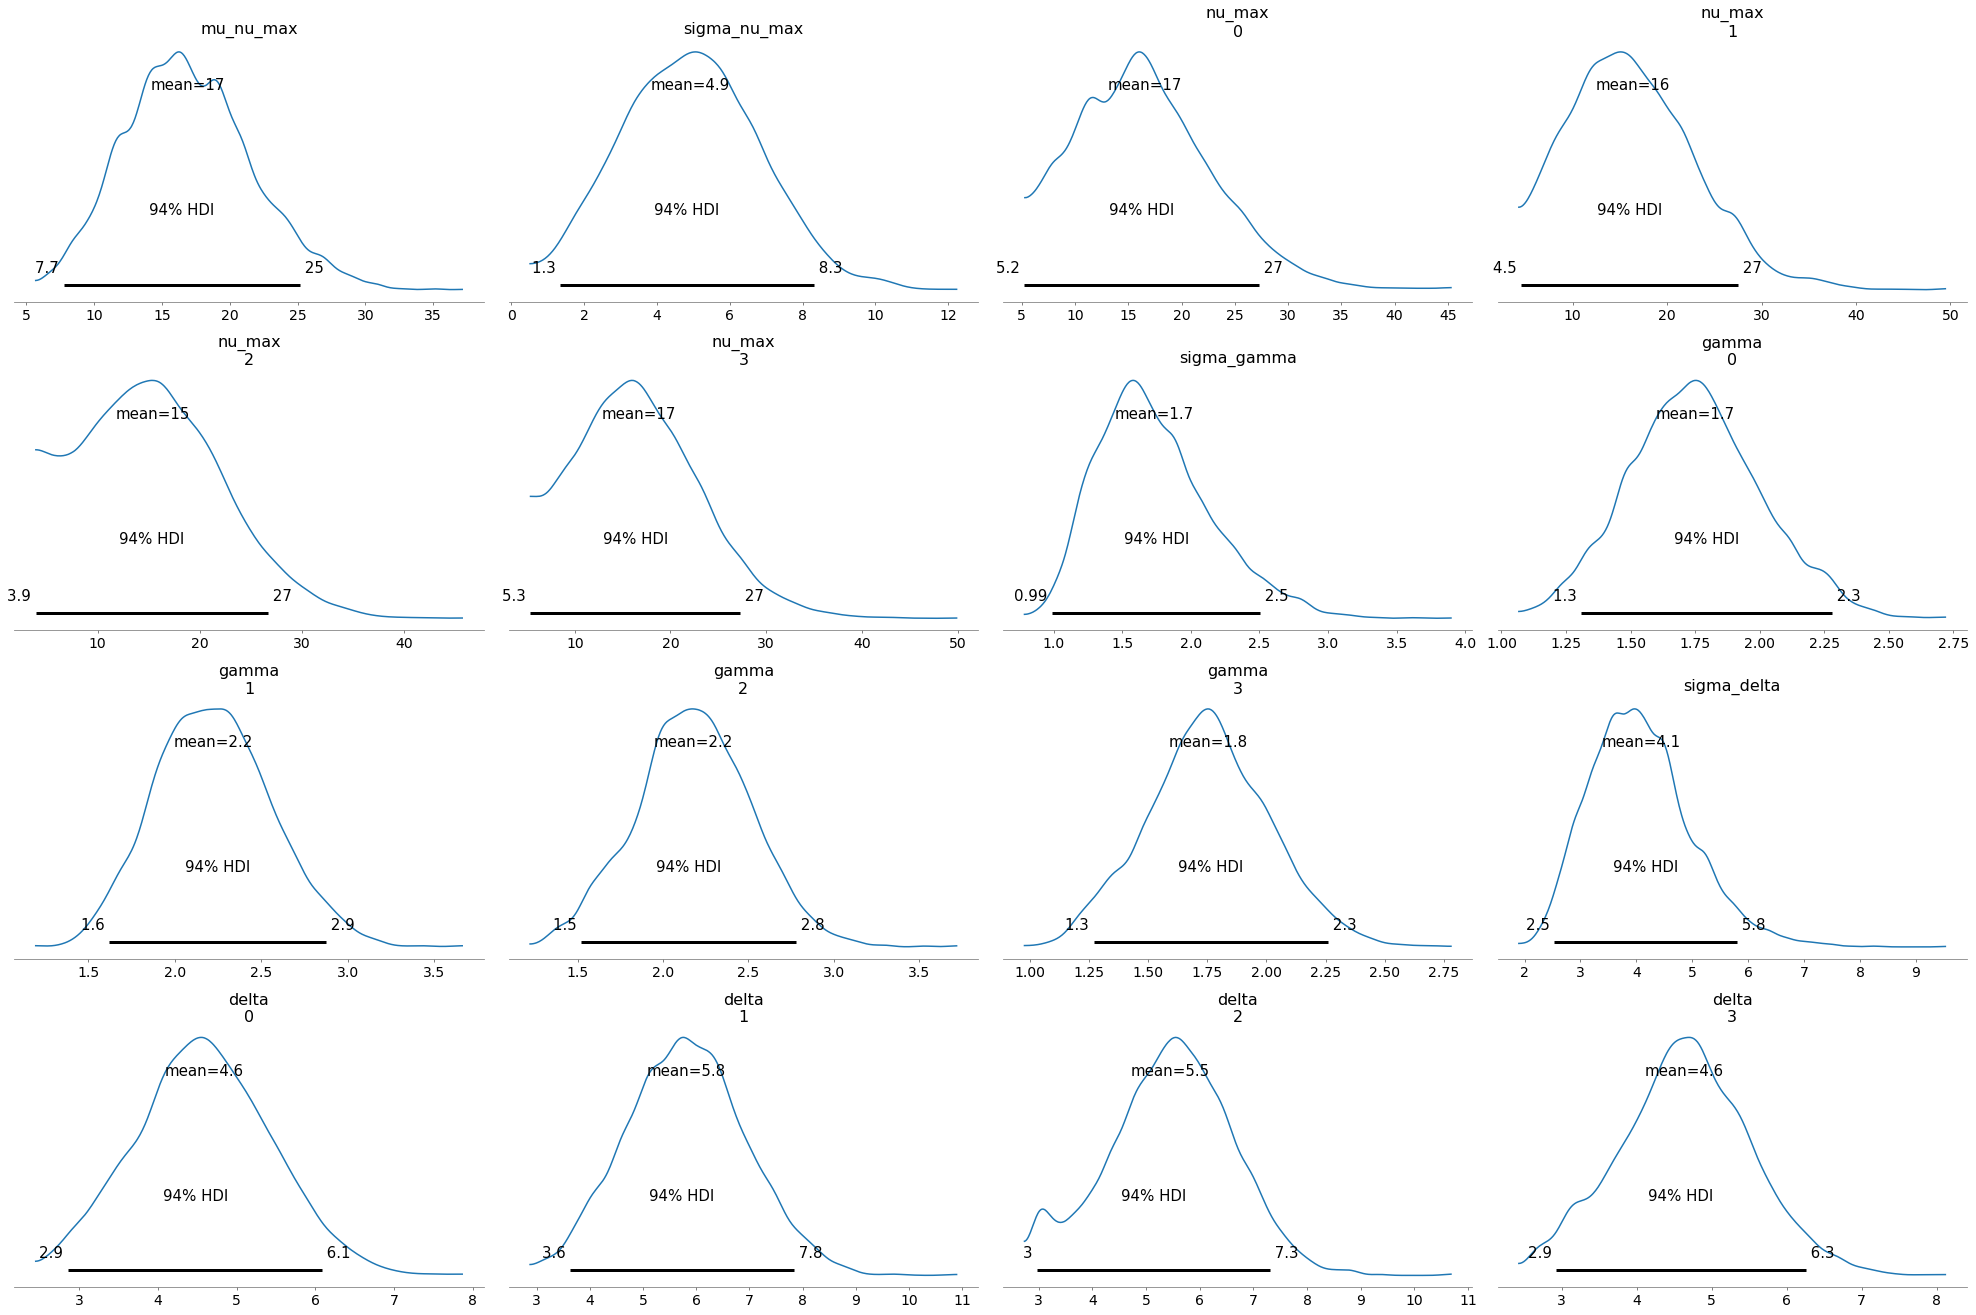

In [12]:
az.plot_posterior(trace)
plt.tight_layout()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

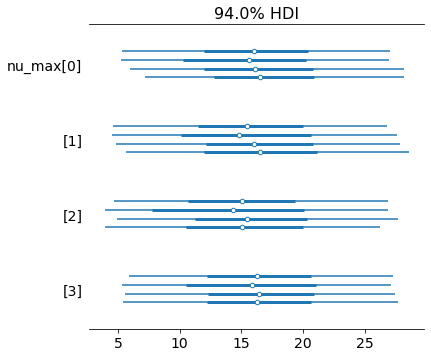

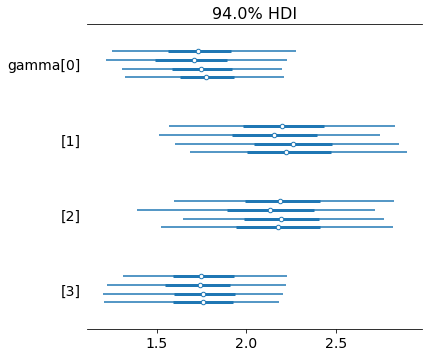

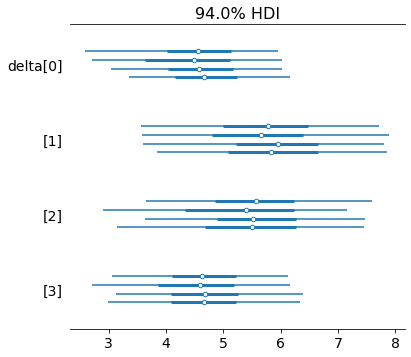

In [13]:
az.plot_forest(trace,var_names=['nu_max'])
az.plot_forest(trace,var_names=['gamma'])
az.plot_forest(trace,var_names=['delta'])

In [14]:
with model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_nu_max,16.93,4.68,7.74,25.20,0.24,0.17,329.45,475.07,1.02
sigma_nu_max,4.92,1.89,1.34,8.31,0.06,0.04,1059.08,1191.02,1.01
nu_max[0],16.59,6.40,5.25,27.23,0.35,0.25,217.43,120.25,1.03
nu_max[1],16.38,6.69,4.55,27.50,0.33,0.24,350.65,863.57,1.02
nu_max[2],15.38,6.76,3.92,26.65,0.41,0.29,190.21,130.80,1.04
nu_max[3],16.68,6.43,5.33,27.29,0.33,0.23,288.14,216.98,1.03
sigma_gamma,1.73,0.42,0.99,2.50,0.02,0.01,495.66,1709.69,1.02
gamma[0],1.75,0.26,1.31,2.28,0.02,0.01,227.13,148.64,1.03
gamma[1],2.22,0.34,1.62,2.87,0.01,0.01,538.46,926.56,1.01
gamma[2],2.18,0.34,1.52,2.78,0.02,0.01,271.17,227.73,1.03


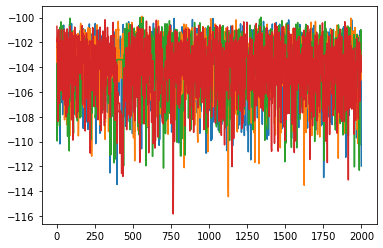

In [15]:
plt.plot(trace.log_likelihood['logP'][0,:,0])
plt.plot(trace.log_likelihood['logP'][1,:,0])
plt.plot(trace.log_likelihood['logP'][2,:,0])
plt.plot(trace.log_likelihood['logP'][3,:,0])



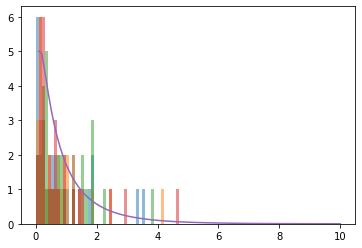

In [16]:
nu = np.linspace(0.1,10.,100)
p, log = logp_raw(nu,1.,0.02,0.005)

for i in range(n):
    plt.hist(NU[:,i],np.linspace(0,5,51),alpha=0.5)
    
plt.plot(nu,p*5)

plt.show()



<h1>Direct Hierarchical inference</h1>
<p>From here on, a variant of the model is set to infer parameters directly, including solving the selfoncistency equation during inference to obtain biological parameters</p>
<p>This is not possible with multiple populations, as the approximate solution to the selfconsistency equation has not (yet?) been found and a numerical solution might take to many resources</p>

In [17]:
with pm.Model() as model:
    # replace normals with student-t distributions
    mu_alpha_0 = pm.HalfNormal('mu_alpha_0',sigma=0.01);
    sigma_alpha_0 = pm.HalfNormal('sigma_alpha_0',sigma=0.02);
    
    alpha_0 = pm.HalfStudentT('alpha_0',sigma=mu_alpha_0,nu=sigma_alpha_0,shape=n);
    
    
    nu_bar = pm.Normal('nu_bar',obs_nu_bar,0.1,shape=n);
    
    
    mu_tau_I = pm.HalfNormal('mu_tau_I',sigma=0.01);
    sigma_tau_I = pm.HalfNormal('sigma_tau_I',sigma=0.01);
    
    #tau_I = pm.TruncatedNormal('tau_I',mu=mu_tau_I,sigma=sigma_tau_I,lower=0.,upper=0.1,shape=n);
    tau_I = pm.Normal('tau_I',mu=mu_tau_I,sigma=sigma_tau_I,shape=n);
    
    
    def likelihood(NU):
        # introduce checks for consistency, etc
        
        nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )
        
        q = approx_q(nu_bar,alpha_0,tau_I)
        
        sigma_I = np.sqrt(J**2 * nu_bar / ( 2 * tau_I ))
        sigma_V = np.sqrt(sigma_I**2 * tau_I / (tau_I + tau_m))
        alpha = np.sqrt(J**2 * q + alpha_0**2)
        
        selfcon_nu = nu_bar/nu_max * np.sqrt( alpha**2/sigma_V**2 + 1)
        selfcon_q = q/nu_max**2 * np.sqrt( 2*alpha**2/sigma_V**2 + 1)
        
        #if ((selfcon_nu < 1) and (selfcon_q < 1)):
        gamma = sigma_V / alpha

        I_0 = np.sqrt( -( alpha**2 + sigma_V**2 ) * np.log( ( nu_bar / nu_max )**2 * ( alpha**2/sigma_V**2 + 1 ) ) )
        delta = I_0 / alpha

        tt.printing.Print('nu_bar')(nu_bar)
        tt.printing.Print('mu_alpha_0')(mu_alpha_0)
        tt.printing.Print('sigma_alpha_0')(sigma_alpha_0)
        tt.printing.Print('alpha_0')(alpha_0)
        tt.printing.Print('mu_tau_I')(mu_tau_I)
        tt.printing.Print('sigma_tau_I')(sigma_tau_I)
        tt.printing.Print('tau_I')(tau_I)

        logP_ = logP_nu(NU,gamma,delta,nu_max)
        logP_ = tt.switch(tt.lt(selfcon_nu,1), logP_, -10000.)
        logP_ = tt.switch(tt.lt(selfcon_q,1), logP_, -10000.)
        logP_ = tt.switch(tt.isnan(logP_), -10000., logP_)
        
        tt.printing.Print('logP_')(tt.sum(logP_))

        #logP_ = tt.switch((selfcon_nu < 1) and (selfcon_q < 1), logP_.sum(), -10000.)
        return logP_.sum()
        
    
    logP = pm.DensityDist('logP',likelihood,observed={'NU':NU})
                   
    trace = pm.sample(
        init='adapt_diag',
        chains=4,draws=2000,tune=2000,
        target_accept=0.8,
        return_inferencedata=True)

nu_bar __str__ = [0.96455556 0.77305556 0.88472222 0.92772222]
mu_alpha_0 __str__ = 0.007978845608028655
sigma_alpha_0 __str__ = 0.01595769121605731
alpha_0 __str__ = [0.00797885 0.00797885 0.00797885 0.00797885]
mu_tau_I __str__ = 0.007978845608028655
sigma_tau_I __str__ = 0.007978845608028655
tau_I __str__ = [0.00797885 0.00797885 0.00797885 0.00797885]
logP_ __str__ = -185.77318576554572
nu_bar __str__ = [0.96455556 0.77305556 0.88472222 0.92772222]
mu_alpha_0 __str__ = 0.007978845608028655
sigma_alpha_0 __str__ = 0.01595769121605731
alpha_0 __str__ = [0.00797885 0.00797885 0.00797885 0.00797885]
mu_tau_I __str__ = 0.007978845608028655
sigma_tau_I __str__ = 0.007978845608028655
tau_I __str__ = [0.00797885 0.00797885 0.00797885 0.00797885]
logP_ __str__ = -185.77318576554572
nu_bar __str__ = [0.96455556 0.77305556 0.88472222 0.92772222]
mu_alpha_0 __str__ = 0.007978845608028655
sigma_alpha_0 __str__ = 0.01595769121605731
alpha_0 __str__ = [0.00797885 0.00797885 0.00797885 0.00797885]

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [tau_I, sigma_tau_I, mu_tau_I, nu_bar, alpha_0, sigma_alpha_0, mu_alpha_0]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 62 seconds.
There were 1306 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6555303618439955, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1389 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6222846378523841, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1232 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1208 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


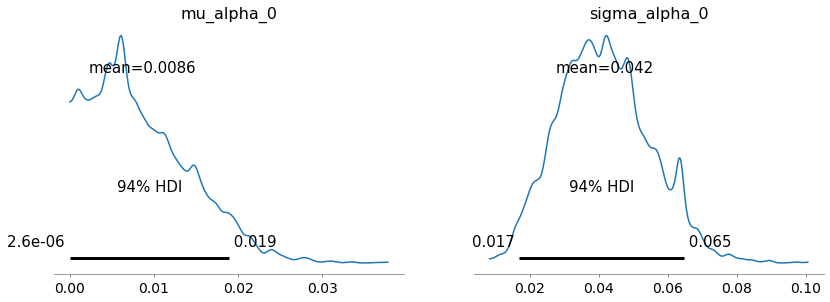

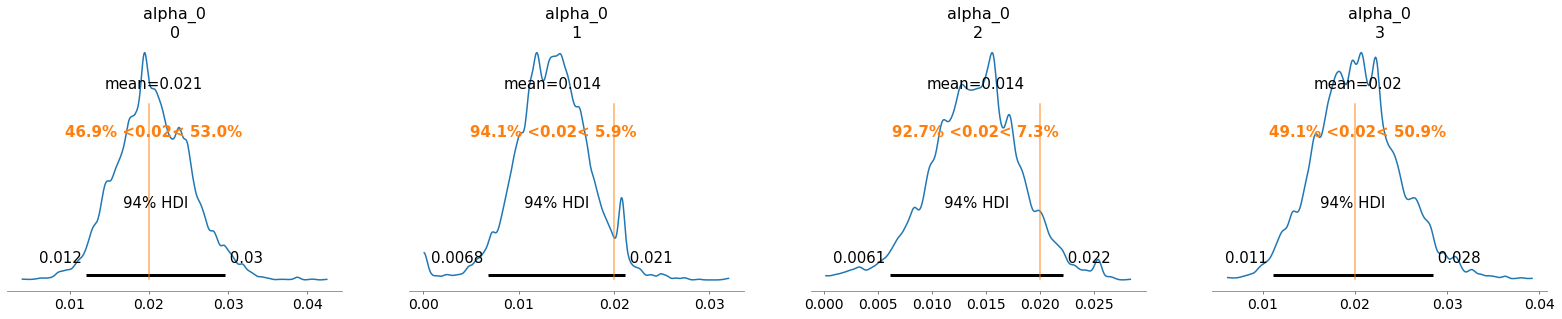

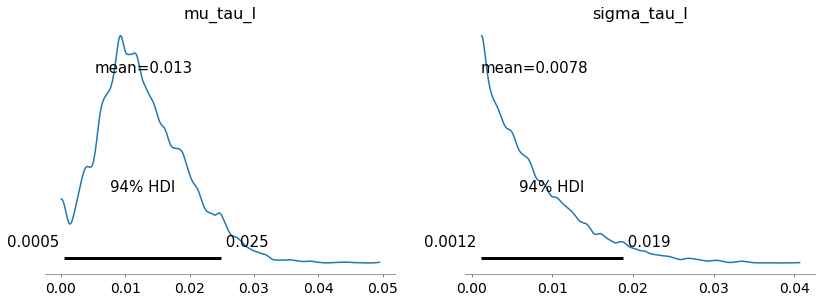

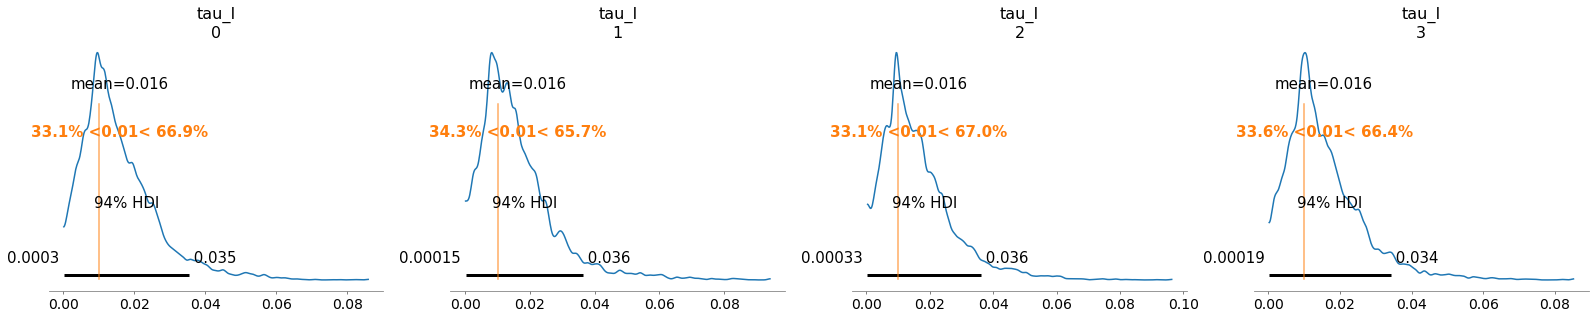

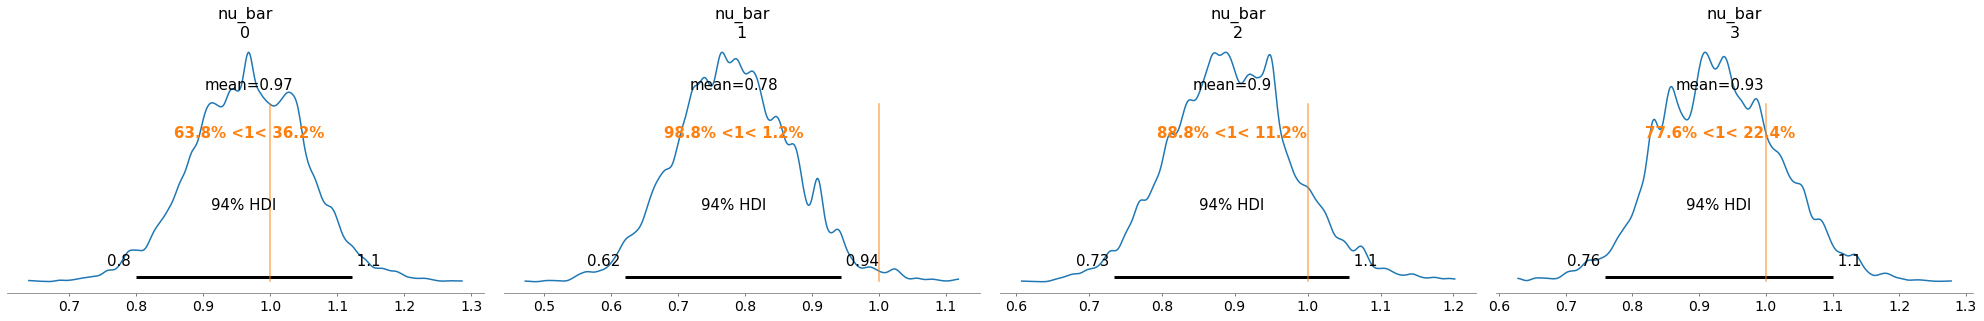

In [18]:
az.plot_posterior(trace,var_names=['_alpha_0$'], filter_vars="regex")
az.plot_posterior(trace,var_names=['^alpha_0'], filter_vars="regex", ref_val=0.02)
az.plot_posterior(trace,var_names=['_tau_I$'], filter_vars="regex")
az.plot_posterior(trace,var_names=['^tau_I'], filter_vars="regex", ref_val=0.01)
az.plot_posterior(trace,var_names=['nu_bar'], ref_val=1)
plt.tight_layout()



(0.0, 0.05)

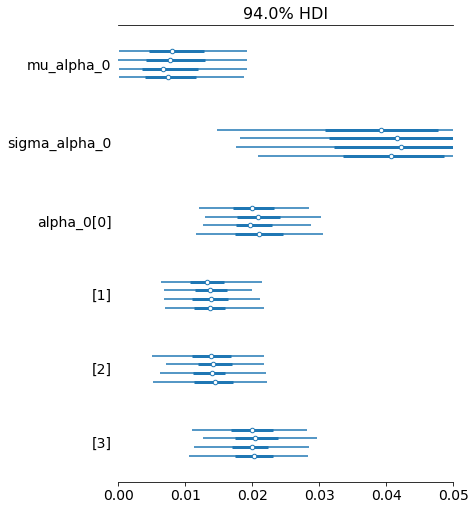

In [19]:
az.plot_forest(trace,var_names=['alpha_0$'], filter_vars='regex')
plt.xlim([0,0.05])

In [20]:
nu = np.linspace(0.,2.,101)
plt.plot(nu,approx_q({'tau_I': 0.005, 'alpha_0': 0.04, 'nu_bar': nu}))
plt.plot(nu,nu**2,'r--')
plt.show()

TypeError: approx_q() missing 2 required positional arguments: 'alpha_0' and 'tau_I'